# Import Packages and Data

In [1]:
oldw <- getOption("warn")
options(warn = -1)

In [2]:
library(readxl)
library(quantreg)
library(dplyr)
library(jtools)
library(MuMIn)
library(plotly)
library(ggplot2)
library(ggpubr)
library(gridExtra)

Loading required package: SparseM


Attaching package: 'SparseM'


The following object is masked from 'package:base':

    backsolve



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout


Registered S3 methods overwritten by 'broom':
  method            from  
  tidy.glht         jtools
  tidy.summary.glht jtools


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [3]:
#Import the center dates, weather information and buoy data
dates <- read_excel("C:/Users/rdeterman/Desktop/data10_14.xlsx", sheet = "Date_Transform", na = "NA")

wea <- read_excel("C:/Users/rdeterman/Desktop/data10_14.xlsx", sheet = "BOS_wea", na = "NA")
wea<- wea[complete.cases(wea), ]
wea$dn <- as.numeric(wea$DateVal)

buoy <- read_excel("C:/Users/rdeterman/Desktop/data10_14.xlsx", sheet = "buoy", na = "NA")
buoy<- buoy[complete.cases(buoy), ]
buoy_dailymean = aggregate(buoy["tempc"], by=buoy["date"], mean)
buoy_dailymean$dn  <- as.numeric(buoy_dailymean$date)

vmm_buoy <- read_excel("C:/Users/rdeterman/Desktop/data10_14.xlsx", sheet = "vmm_and_buoy")

New names:
* `` -> ...13



In [4]:
#Import the excel spreadsheeet and convert the date to a datenum variable type
vmm <- read_excel("C:/Users/rdeterman/MATLAB/data01_11.xlsx", na = "NA")
vmm$dn  <- as.numeric(vmm$DATE)

#setting the date as a number and centering it around zero
count <- seq.int(1,955)
for (b in count) {               
        target_date <- vmm$DATE[b]
        target_row   <- match(target_date,dates$date) 
        vmm$cd[b] <- dates$subtractedfrommean[target_row]
}

## Linear model function

In [5]:
lm_res <- function(eq, data, alpha) {
    mdl <-lm(eq,data=data)
    print(confint(mdl, level = alpha))
    print(summary(mdl))
}
a = 0.995

# Equation 1: Converting air temperature to water temperature

In [6]:
#take the sample collection dates and sample values.
# for each date range find the average of the comparison quantity (precip, temp)
#target dates = sample collection dates
#long dates = dates of the comparison thing -- precip/ temp
#long data to match -- the comparison precip/ temp values
#corr comparer - value of the sample collected

range_means <- function(target_dates, long_dates, long_data_to_match, corr_comparer) {
    #print(corr_comparer)
    
    #length of samples array
    b_count <- seq(1,length(target_dates))
    
    #dayrange to compare over
    range <- seq(1,90)  
    
    #empty dataframe to store the range means 
    #length = number of samples
    #columns = 90; there are 90 range comparisons 1,2,3,4,5,6...,88,89,89
    means <- data.frame(matrix(NA, nrow = length(target_dates), ncol =90))
    
    #for each value in the sample array
    for (b in b_count) { 
        #what is the date of the sample?
        target_date <- target_dates[b] 
        
        #where is the matching date on the comparison array?
        wea_row <- match(target_date,long_dates) 
        
        #for each day range; compare that many days back and find the mean
        #store the mean in the means dataframe
        for (r in range){
            rows <- seq.int(from = wea_row-r,to = wea_row) 
            val <-  mean(long_data_to_match[rows])
            means[b,r]<- val
             }   
        }
    
    aicc_ = vector()
    
    for (r in range){
        x<- pull(means, r)
        y<- corr_comparer
        df <- data.frame(x,y)
       
        mdl<-lm('y~ 1+x', data = df)
        aicc_[r] =AICc(mdl)
        }
    target_col = which(aicc_==min(aicc_))
    print(target_col)
    return(means[,target_col])   
}

In [7]:
at7 <- range_means(buoy_dailymean$date,wea$DateVal,wea$TAVEC, buoy_dailymean$tempc)
buoy_dailymean$airtemp_7day <- at7
linearMod <- lm(tempc ~ airtemp_7day, data=buoy_dailymean) 
summary(linearMod)
confint(linearMod, level = 0.995)

[1] 7



Call:
lm(formula = tempc ~ airtemp_7day, data = buoy_dailymean)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.3733 -1.2050 -0.2516  1.0868  5.2997 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.60335    0.26739   13.48   <2e-16 ***
airtemp_7day  0.93046    0.01326   70.18   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.643 on 758 degrees of freedom
Multiple R-squared:  0.8666,	Adjusted R-squared:  0.8664 
F-statistic:  4925 on 1 and 758 DF,  p-value: < 2.2e-16


,0.25 %,99.75 %
(Intercept),2.8505852,4.3561242
airtemp_7day,0.8931297,0.9677843


In [8]:
vmm$airtemp_7day <- NA
b_count <- seq(1,955)
r = 7 

for (b in b_count) { 
    target_date <- vmm$DATE[b] 
    wea_row <- match(target_date,wea$DateVal) 
    rows <- seq.int(from = wea_row-r,to = wea_row) 
    val <-  mean(wea$TAVEC[rows])
    vmm$airtemp_7day[b]<- val
    }   

vmm$pred_watertemp<- predict(linearMod, vmm)
vmm$pred_watertemp_center <- vmm$pred_watertemp−mean(vmm$pred_watertemp)

# Figure 2 draft: Total P, Chl-*a*, and phycocyanin vs. time

In [9]:
a_val <- as.numeric(as.Date("1997-05-01")) * 24 * 60 * 60 * 1000
b <- as.numeric(as.Date("2019-11-15")) * 24 * 60 * 60 * 1000
lgc = (vmm$basin1 == 1)
sz <-5
notbasin_marker <- list(color = 'rgba(33, 28, 145,0.8)',
                        size = sz,
                        line = list(color = 'rgb(255, 255, 255)',
                                    width = 0.5))
basin_marker <- list(color = 'rgba(195, 7, 0,0.8)',
                     size = sz,
                     line = list(color = 'rgb(255, 255, 255)',
                                 width = 0.5))

TP_time <- plot_ly(type = 'scatter', mode = 'markers',width = 1400, height = 700)
TP_time <- TP_time %>% layout(xaxis = list(range = c(a_val, b),showgrid = TRUE,automargin = TRUE), 
                        yaxis = list(title = "Total Phosphorus mg/l",showgrid = TRUE,
                                    type = "log"),
                        autosize = T)
TP_time <- TP_time %>%
        add_trace(
            x = vmm$DATE[!lgc],
            y = vmm$TP[!lgc],
            marker = notbasin_marker,
          showlegend = F
          ) 
TP_time <- TP_time %>%
        add_trace(
            x = vmm$DATE[lgc],
            y = vmm$TP[lgc],
            marker = basin_marker, 
          showlegend = F
          ) 

CA_time <- plot_ly(type = 'scatter', mode = 'markers',width = 1400, height = 700) 
CA_time <- CA_time %>%
        add_trace(
            x = vmm$DATE[!lgc],
            y = vmm$CA[!lgc],
            name = 'Non-Basin',
            marker = notbasin_marker,
          showlegend = T
          ) 
CA_time <- CA_time %>%
        add_trace(
            x = vmm$DATE[lgc],
            y = vmm$CA[lgc],
            name = 'Basin',
            marker = basin_marker,
          showlegend = T
          )
CA_time <- CA_time %>% layout(xaxis = list(range = c(a_val, b),automargin = TRUE), 
                        yaxis = list(title = "Chlorophyll a ug/l",showgrid = TRUE,
                                     type = "log"),
                        margin = list(r = 0.0))
                        #legend = list(x = 0.9, y = 0.99))

phy_time <- plot_ly(type = 'scatter', mode = 'markers',width = 1400, height = 700) 
phy_time <- phy_time %>% layout(xaxis = list(range = c(a_val, b),showgrid = TRUE,automargin = TRUE), 
                        yaxis = list(title = "Phycocyanin RFU",showgrid = TRUE),
                        margin = list(b = 160))
phy_time <- phy_time %>%
        add_trace(
            x = buoy$dt,
            y = buoy$phy,
            marker = basin_marker,
          showlegend = F
          ) 

fig2 <- subplot(TP_time,CA_time, phy_time, nrows = 3,shareX = TRUE, titleY = TRUE)
#fig2 <- fig2 %>% layout(autosize = T,xaxis = list(type = "date"))
#embed_notebook(fig2)

# Equation 2: Chl-*a* vs. time

In [10]:
eq= "CA ~ 1 + centerdate"
lm_res(eq,vmm,a)

                  0.25 %       99.75 %
(Intercept)  7.066027408  9.444201e+00
centerdate  -0.001096042 -9.816826e-05

Call:
lm(formula = eq, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
 -9.637  -6.448  -4.625   0.629 115.554 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.2551144  0.4226232  19.533  < 2e-16 ***
centerdate  -0.0005971  0.0001773  -3.367  0.00079 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 13.06 on 953 degrees of freedom
Multiple R-squared:  0.01176,	Adjusted R-squared:  0.01072 
F-statistic: 11.34 on 1 and 953 DF,  p-value: 0.0007898



# Equation 3: Total P vs. time

In [11]:
eq= "TP ~ 1 + cd"
lm_res(eq,vmm,a)

                   0.25 %       99.75 %
(Intercept)  6.164455e-02  6.756305e-02
cd          -5.324798e-06 -2.782917e-06

Call:
lm(formula = eq, data = data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.058740 -0.020753 -0.004388  0.015457  0.275692 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.460e-02  1.052e-03  61.432   <2e-16 ***
cd          -4.054e-06  4.517e-07  -8.976   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0316 on 902 degrees of freedom
  (51 observations deleted due to missingness)
Multiple R-squared:  0.08199,	Adjusted R-squared:  0.08097 
F-statistic: 80.56 on 1 and 902 DF,  p-value: < 2.2e-16



# Table 2: Quantile Regression
Chl-*a* vs time  
Total P vs time

In [12]:
alpha<- 0.005
data<- vmm
tau<- c(0.01,0.05,0.25, 0.5,0.75,0.80,0.85,0.86,0.95,0.99)

eq<- 'CA ~ 1 + centerdate'
for (t in tau){
    mdl <- rq(eq, tau = t, alpha = alpha, data = data)
    print(summ(mdl, confint= TRUE, ci.width = 0.995,digits = 6))
}

MODEL INFO:
Observations: 955
Dependent Variable: CA
Type: Quantile regression
  Quantile (tau): 0.01
  Method: Barrodale-Roberts 

MODEL FIT:
R¹(0.01) = 0.004383 

Standard errors: Sandwich (Huber)
---------------------------------------------------------------------------
                         Est.        0.3%      99.8%      t val.          p
----------------- ----------- ----------- ---------- ----------- ----------
(Intercept)          0.501684    0.373733   0.629636   11.031769   0.000000
centerdate          -0.000033   -0.000081   0.000014   -1.968692   0.049278
---------------------------------------------------------------------------
MODEL INFO:
Observations: 955
Dependent Variable: CA
Type: Quantile regression
  Quantile (tau): 0.05
  Method: Barrodale-Roberts 

MODEL FIT:
R¹(0.05) = 0.007508 

Standard errors: Sandwich (Huber)
----------------------------------------------------------------------------
                         Est.        0.3%       99.8%      t val.    

In [13]:
eq<- 'TP ~ 1 + centerdate'
tau<- c(0.01,0.05,0.25, 0.5,0.75,0.80,0.85, 0.90,0.95,0.96,0.99)
for (t in tau){
    mdl <- rq(eq, tau = t, alpha = alpha, data = data)
    print(summ(mdl, confint= TRUE, ci.width = 0.995,digits = 8))
}

MODEL INFO:
Observations: 904 (51 missing obs. deleted)
Dependent Variable: TP
Type: Quantile regression
  Quantile (tau): 0.01
  Method: Barrodale-Roberts 

MODEL FIT:
R¹(0.01) = 0.00425133 

Standard errors: Sandwich (Huber)
------------------------------------------------------------------------
                           Est.          0.3%        99.8%        t val.
----------------- ------------- ------------- ------------ -------------
(Intercept)          0.01916794    0.01460112   0.02373476   11.81079231
centerdate          -0.00000041   -0.00000238   0.00000156   -0.58673232
------------------------------------------------------------------------
 
------------------------------
                             p
----------------- ------------
(Intercept)         0.00000000
centerdate          0.55753031
------------------------------
MODEL INFO:
Observations: 904 (51 missing obs. deleted)
Dependent Variable: TP
Type: Quantile regression
  Quantile (tau): 0.05
  Method: Barrodale

# Equation 4: Total P vs. time (River)

In [14]:
lgc = (vmm$basin1 == 0)
eq = "TP ~ 1 + cd"
a = 0.995
lm_res(eq, vmm[lgc,],a)

                   0.25 %       99.75 %
(Intercept)  6.010695e-02  6.685602e-02
cd          -5.726992e-06 -2.823920e-06

Call:
lm(formula = eq, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.05843 -0.02064 -0.00574  0.01533  0.27594 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.348e-02  1.199e-03  52.962  < 2e-16 ***
cd          -4.275e-06  5.156e-07  -8.292 5.08e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03294 on 754 degrees of freedom
  (45 observations deleted due to missingness)
Multiple R-squared:  0.08358,	Adjusted R-squared:  0.08236 
F-statistic: 68.76 on 1 and 754 DF,  p-value: 5.083e-16



# Equation 5: Total P vs. time (Basin)

In [15]:
lgc = (vmm$basin1 ==1)
eq = "TP ~ 1 + cd"
lm_res(eq, vmm[lgc,],a)

                   0.25 %       99.75 %
(Intercept)  6.495091e-02  7.564937e-02
cd          -5.253877e-06 -6.948193e-07

Call:
lm(formula = eq, data = data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.037728 -0.017738 -0.003262  0.015495  0.065413 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.030e-02  1.877e-03  37.459  < 2e-16 ***
cd          -2.974e-06  7.997e-07  -3.719 0.000284 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02283 on 146 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.08654,	Adjusted R-squared:  0.08028 
F-statistic: 13.83 on 1 and 146 DF,  p-value: 0.0002844



# Equation 6: Chl-*a* vs. time (River)

In [16]:
lgc = (vmm$basin1 ==0)
eq = "CA ~ 1 + cd"
lm_res(eq, vmm[lgc,],a)

                   0.25 %       99.75 %
(Intercept)  6.0696205884  8.4142714592
cd          -0.0009981072 -0.0000138057

Call:
lm(formula = eq, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
 -8.227  -5.580  -3.972   0.314 111.546 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.2419460  0.4164784  17.389  < 2e-16 ***
cd          -0.0005060  0.0001748  -2.894  0.00391 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 11.78 on 799 degrees of freedom
Multiple R-squared:  0.01037,	Adjusted R-squared:  0.009134 
F-statistic: 8.374 on 1 and 799 DF,  p-value: 0.00391



# Chl-*a* vs. time (Basin)

In [17]:
lgc = (vmm$basin1 ==1)
eq = "CA ~ 1 + cd"
lm_res(eq, vmm[lgc,],a)

                  0.25 %      99.75 %
(Intercept)  9.737739312 17.725334026
cd          -0.002768669  0.000569407

Call:
lm(formula = eq, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.447 -10.371  -5.942   2.832 109.972 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 13.7315367  1.4020257   9.794   <2e-16 ***
cd          -0.0010996  0.0005859  -1.877   0.0625 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 17.39 on 152 degrees of freedom
Multiple R-squared:  0.02265,	Adjusted R-squared:  0.01622 
F-statistic: 3.522 on 1 and 152 DF,  p-value: 0.06247



# Figure 3 draft: Boxplots of Nutrients 

In [18]:
fns <- function(series) {
    print(summary(series[vmm$basin1 == 0]))
    print(length(series[vmm$basin1 == 0])-summary(series[vmm$basin1 == 0])[7][1])
    print(summary(series[vmm$basin1 == 1]))
    print(length(series[vmm$basin1 == 1])-summary(series[vmm$basin1 == 1])[7][1])
}

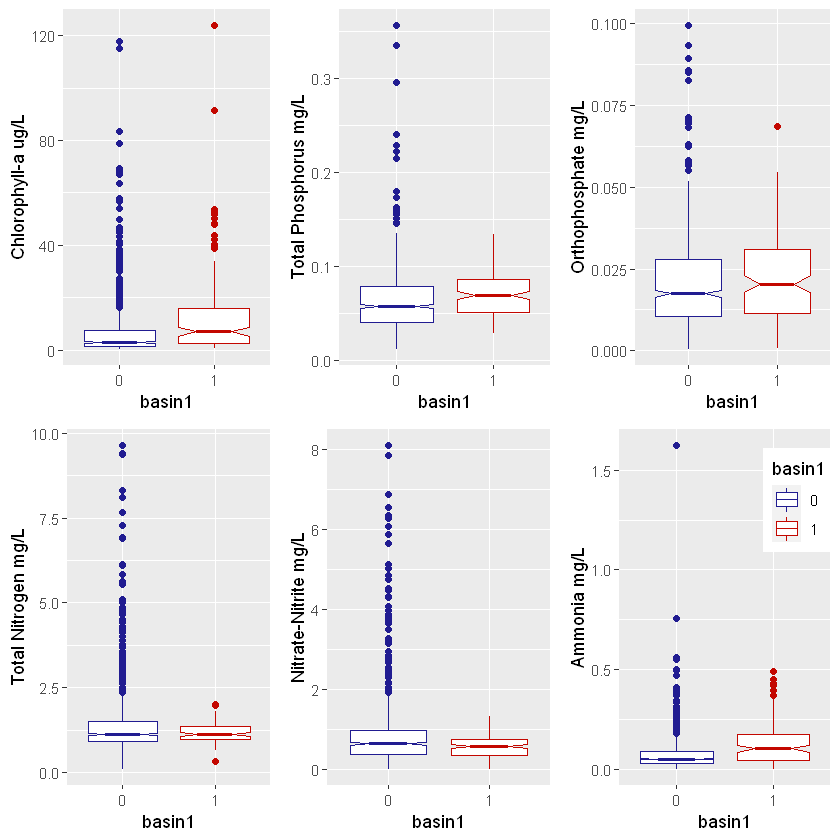

In [19]:
vmm$basin1 <- as.factor(vmm$basin1)
p1<- ggplot(vmm, aes(x=basin1, y=TP,color=basin1)) + 
  geom_boxplot(notch = TRUE) + ylab('Total Phosphorus mg/L') +
  scale_color_manual(values=c("#211c91", "#c30700")) +
  theme(legend.position = "none")
p2<- ggplot(vmm, aes(x=basin1, y=OP,color=basin1)) + 
  geom_boxplot(notch = TRUE)+ ylab('Orthophosphate mg/L')+
  scale_color_manual(values=c("#211c91", "#c30700")) +
  theme(legend.position = "none")
p3<- ggplot(vmm, aes(x=basin1, y=TN,color=basin1)) + 
  geom_boxplot(notch = TRUE)+ ylab('Total Nitrogen mg/L') + 
  scale_color_manual(values=c("#211c91", "#c30700")) +
  theme(legend.position = "none")
p4<- ggplot(vmm, aes(x=basin1, y=NN,color=basin1)) + 
  geom_boxplot(notch = TRUE) + ylab('Nitrate-Nitrite mg/L') +
  scale_color_manual(values=c("#211c91", "#c30700"))  +
  theme(legend.position = "none")
p5<- ggplot(vmm, aes(x=basin1, y=ammonia,color=basin1)) + 
  geom_boxplot(notch = TRUE) + ylab('Ammonia mg/L') +
  scale_color_manual(values=c("#211c91", "#c30700")) +
  theme(legend.position = c(0.85, .8))

p6<- ggplot(vmm, aes(x=basin1, y=CA,color=basin1)) + 
  geom_boxplot(notch = TRUE) + ylab('Chlorophyll-a ug/L') +
  scale_color_manual(values=c("#211c91", "#c30700")) +
  theme(legend.position = "none")

grid.arrange(p6,p1, p2, p3,p4,p5, nrow = 2)

In [20]:
fns(vmm$TP)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.01239 0.04086 0.05751 0.06383 0.07891 0.35620      45 
NA's 
 756 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.02920 0.05135 0.06954 0.07045 0.08650 0.13385       6 
NA's 
 148 


In [21]:
fns(vmm$TN)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.1031  0.9203  1.1206  1.4526  1.4944  9.6448      42 
NA's 
 759 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.3322  0.9765  1.1267  1.1678  1.3500  2.0200       8 
NA's 
 146 


In [22]:
fns(vmm$OP)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00051 0.01048 0.01741 0.02068 0.02784 0.09940      38 
NA's 
 763 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00070 0.01145 0.02033 0.02187 0.03110 0.06839       6 
NA's 
 148 


In [23]:
fns(vmm$NN)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00158 0.37400 0.63452 0.87477 0.95668 8.09404      28 
NA's 
 773 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00035 0.35130 0.56008 0.53862 0.74484 1.32000       4 
NA's 
 150 


In [24]:
fns(vmm$ammonia)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00000 0.02721 0.05042 0.07369 0.08727 1.62481      10 
NA's 
 791 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00000 0.04341 0.10200 0.12409 0.17300 0.49000       3 
NA's 
 151 


In [25]:
fns(vmm$CA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.350   1.540   2.930   7.219   7.370 118.000 
<NA> 
     
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.710   2.465   7.010  13.643  15.950 124.000 
<NA> 
     


# Logit Regression

## Basin

In [26]:
vmm$month <- as.double(format(vmm$DATE, "%m"))
vmm$Year <- as.double(format(vmm$DATE, "%Y"))
#APRIL to October
basin<- vmm[(vmm$basin1 ==1),]
lgc <- (basin$month >= 4 & basin$month <=10)
apr_oct_b <- basin[lgc,]

In [27]:
#apr_oct_b <- apr_oct_b[complete.cases(apr_oct$CA), ]
apr_oct_b <- apr_oct_b %>%
    group_by(Year) %>%
    summarise(mean_CA = mean(CA, na.rm = TRUE))

apr_oct_b$pass_fail <- as.integer(apr_oct_b$mean_CA < 10)
apr_oct_b$ctr_yr <- apr_oct_b$Year -mean(apr_oct_b$Year)

`summarise()` ungrouping output (override with `.groups` argument)



In [28]:
model_weight <- glm(pass_fail ~ ctr_yr, data = apr_oct_b, family = "binomial")
summary(model_weight)


Call:
glm(formula = pass_fail ~ ctr_yr, family = "binomial", data = apr_oct_b)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3481  -0.6092  -0.3229  -0.1776   1.8886  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  -1.8208     0.7667  -2.375   0.0176 *
ctr_yr        0.2214     0.1152   1.922   0.0546 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 24.085  on 22  degrees of freedom
Residual deviance: 18.541  on 21  degrees of freedom
AIC: 22.541

Number of Fisher Scoring iterations: 5


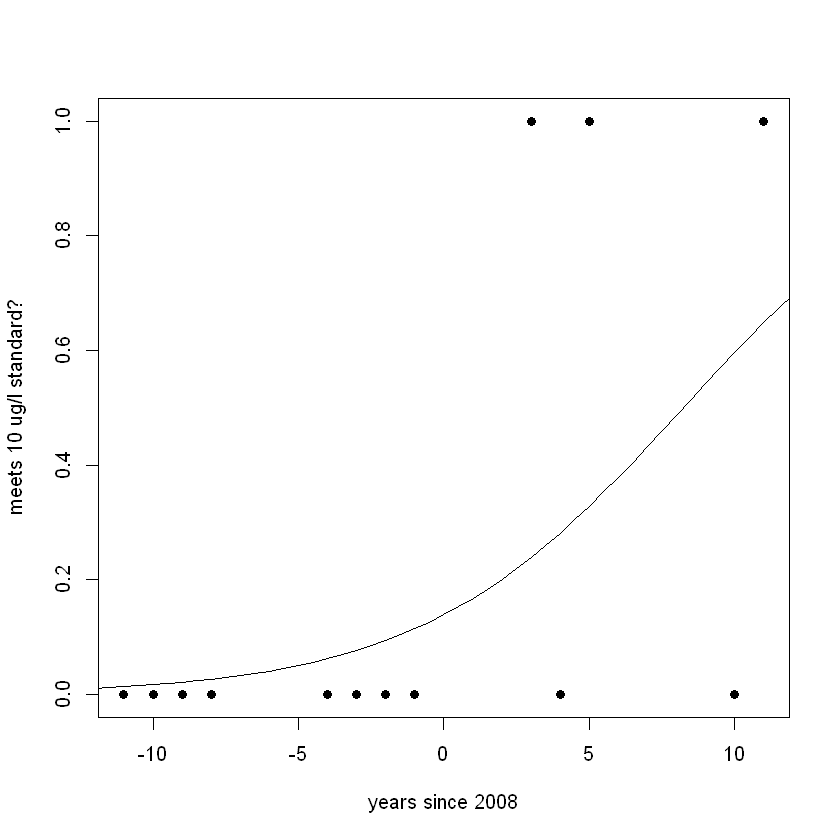

In [29]:
xweight <- seq(-15,15,0.5)
yweight <- predict(model_weight, list(ctr_yr = xweight),type="response")

plot(apr_oct_b$ctr_yr[lgc], apr_oct_b$pass_fail[lgc], pch = 16, xlab = "years since 2008", ylab = "meets 10 ug/l standard?")
lines(xweight, yweight)

## River/ not-basin

`summarise()` ungrouping output (override with `.groups` argument)




Call:
glm(formula = pass_fail ~ ctr_yr, family = "binomial", data = apr_oct_nb)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7885  -1.1155   0.6984   0.9223   1.1847  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.67832    0.46065   1.473    0.141
ctr_yr       0.08692    0.07105   1.223    0.221

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 29.720  on 22  degrees of freedom
Residual deviance: 28.109  on 21  degrees of freedom
AIC: 32.109

Number of Fisher Scoring iterations: 4


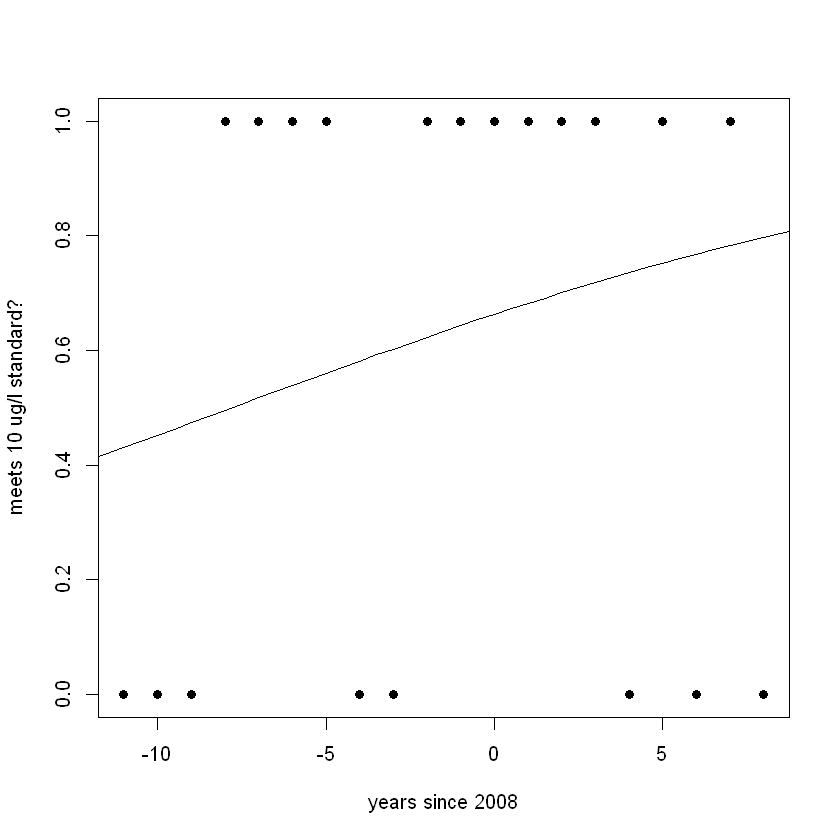

In [30]:
vmm$month <- as.double(format(vmm$DATE, "%m"))
vmm$Year <- as.double(format(vmm$DATE, "%Y"))
#APRIL to October
nb<- vmm[(vmm$basin1 ==0),]
lgc <- (nb$month >= 4 & nb$month <=10)
apr_oct_nb <- nb[lgc,]

#apr_oct_b <- apr_oct_b[complete.cases(apr_oct$CA), ]
apr_oct_nb <- apr_oct_nb %>%
    group_by(Year) %>%
    summarise(mean_CA = mean(CA, na.rm = TRUE))

apr_oct_nb$pass_fail <- as.integer(apr_oct_nb$mean_CA < 10)
apr_oct_nb$ctr_yr <- apr_oct_b$Year -mean(apr_oct_nb$Year)

model_weight <- glm(pass_fail ~ ctr_yr, data = apr_oct_nb, family = "binomial")
summary(model_weight)

xweight <- seq(-15,15,0.5)
yweight <- predict(model_weight, list(ctr_yr = xweight),type="response")

plot(apr_oct_nb$ctr_yr[lgc], apr_oct_nb$pass_fail[lgc], pch = 16, xlab = "years since 2008", ylab = "meets 10 ug/l standard?")
lines(xweight, yweight)

# Equation 7: Chl-*a* vs. TP

In [31]:
eq= "CA ~ 1 + TP"
lm_res(eq, vmm,a)

                0.25 %    99.75 %
(Intercept) -0.9294381   4.391732
TP          63.5874460 136.684836

Call:
lm(formula = eq, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.830  -5.895  -3.726   1.164 109.242 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.7311     0.9455   1.831   0.0674 .  
TP          100.1361    12.9884   7.710 3.33e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.87 on 902 degrees of freedom
  (51 observations deleted due to missingness)
Multiple R-squared:  0.06182,	Adjusted R-squared:  0.06078 
F-statistic: 59.44 on 1 and 902 DF,  p-value: 3.327e-14



In [32]:
a = 0.995
eq= "CA ~ -1 + TP"
lm_res(eq, vmm,a)

    0.25 %  99.75 %
TP 104.779 137.9051

Call:
lm(formula = eq, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.652  -5.530  -3.035   1.618 108.215 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)    
TP  121.342      5.886   20.61   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.88 on 903 degrees of freedom
  (51 observations deleted due to missingness)
Multiple R-squared:   0.32,	Adjusted R-squared:  0.3193 
F-statistic:   425 on 1 and 903 DF,  p-value: < 2.2e-16



# Equation 8: Chl-*a* vs. TN:TP ratio

In [33]:
eq <- "CA ~ 1 + ratio"
lm_res(eq, vmm,a)

                0.25 %     99.75 %
(Intercept)  8.7388539 12.27478032
ratio       -0.1299535 -0.03546017

Call:
lm(formula = eq, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
 -8.870  -6.956  -4.715   1.145 114.464 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.50682    0.62825  16.724   <2e-16 ***
ratio       -0.08271    0.01679  -4.926    1e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 13.2 on 885 degrees of freedom
  (68 observations deleted due to missingness)
Multiple R-squared:  0.02669,	Adjusted R-squared:  0.02559 
F-statistic: 24.27 on 1 and 885 DF,  p-value: 1.001e-06



# Equation 9: TN:TP ratio vs. time

In [34]:
eq<- "ratio ~ 1 + cy" 
lm_res(eq, vmm, a)

                0.25 %   99.75 %
(Intercept) 24.3891278 29.310467
cy           0.3795008  1.154706

Call:
lm(formula = eq, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-26.246 -12.084  -5.727   2.402 292.918 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  26.8498     0.8744  30.706  < 2e-16 ***
cy            0.7671     0.1377   5.569 3.39e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 25.98 on 885 degrees of freedom
  (68 observations deleted due to missingness)
Multiple R-squared:  0.03386,	Adjusted R-squared:  0.03277 
F-statistic: 31.02 on 1 and 885 DF,  p-value: 3.392e-08



#  Figure 5 draft: TN vs Chl-*a*, TN:TP vs Chl-*a*, TP vs Chl-*a* 

In [35]:
figTN <- ggplot(vmm, aes(x=TN, y=CA, color=as.factor(basin1))) + 
    geom_point(size=1.5, alpha = 0.75)+
    scale_x_log10()+
    scale_y_log10()+
    scale_color_manual(values = c("#211c91", "#c30700"))+
    theme(legend.position = "none")


figTNTP <- ggplot(vmm, aes(x=ratio, y=CA, color=as.factor(basin1))) + 
    geom_point(size=1.5, alpha = 0.75)+
    scale_x_log10()+
    scale_y_log10()+
    scale_color_manual(values=c("#211c91", "#c30700")) +
    theme(legend.position = "none") + 
    geom_vline(xintercept=7)+ geom_vline(xintercept=29)


figTP <- ggplot(vmm, aes(x=TP, y=CA, color=as.factor(basin1))) + 
    geom_point(size=1.5, alpha = 0.75)+
    scale_x_log10()+
    scale_y_log10()+
    scale_color_manual(values=c("#211c91", "#c30700")) +
    theme(legend.position = c(0.91, 0.07))

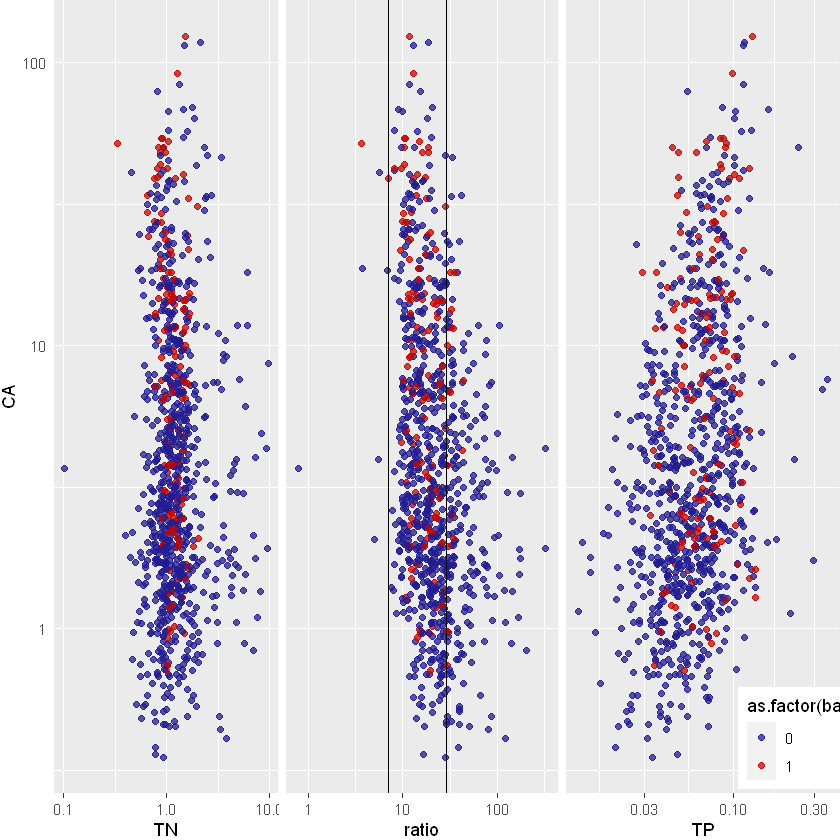

In [36]:
plot3<- ggarrange(figTN +
               theme(axis.ticks.y = element_blank(),
                     plot.margin = margin(r = 1) ), 
          figTNTP + 
               theme(axis.text.y = element_blank(),
                     axis.ticks.y = element_blank(),
                     axis.title.y = element_blank(),
                     plot.margin = margin(r = 1, l = 1) ), 
          figTP +
               theme(axis.text.y = element_blank(),
                     axis.ticks.y = element_blank(),
                     axis.title.y = element_blank(),
                     plot.margin = margin(l = 1)  ),
          nrow = 1) 
#ggsave(plot3, filename = "multi.page.ggplot2.svg")
plot3

# Multiple quantile regression coefficients

## Finding the strongest correlation between chlorophyll-*a* and mean precipitation

In [37]:
vmm$prcp73 <- range_means(vmm$DATE,wea$DateVal,wea$PRCPmm, vmm$CA)

[1] 73


## Fitting the quantile regression models

In [38]:
vmm_model <- data.frame(vmm$CA, vmm$pred_watertemp, vmm$TP, vmm$basin1, vmm$prcp73)#, vmm$TN,vmm$OP,vmm$NN)
colnames(vmm_model) <- c('CA', 'pred_watertemp', 'TP', 'basin1', 'prcp73')#, 'TN', 'OP', 'NN')
vmm_model<- vmm_model[complete.cases(vmm_model), ]

In [39]:
eq<- 'CA ~ 1 + pred_watertemp + TP + basin1 + prcp73'
alpha<- 0.005
data<- vmm_model

## 0.25

In [40]:
tau<- 0.25

mdl <- rq(eq, tau = tau, alpha = alpha, data = data)
s<- summ(mdl, confint= TRUE, ci.width = 0.995,digits = 6)
print(s)

MODEL INFO:
Observations: 904
Dependent Variable: CA
Type: Quantile regression
  Quantile (tau): 0.25
  Method: Barrodale-Roberts 

MODEL FIT:
R¹(0.25) = 0.052836 

Standard errors: Sandwich (Huber)
--------------------------------------------------------------------------------
                            Est.        0.3%       99.8%       t val.          p
-------------------- ----------- ----------- ----------- ------------ ----------
(Intercept)             2.331271    1.560067    3.102474     8.506380   0.000000
pred_watertemp          0.066580    0.033746    0.099415     5.706101   0.000000
TP                      9.948800    1.766651   18.130949     3.421562   0.000651
basin11                 1.010853    0.223099    1.798608     3.610924   0.000322
prcp73                 -0.637790   -0.793134   -0.482447   -11.553283   0.000000
--------------------------------------------------------------------------------


## 0.50

In [41]:
tau<- 0.50

mdl <- rq(eq, tau = tau, alpha = alpha, data = data)
s<- summ(mdl, confint= TRUE, ci.width = 0.995,digits = 6)
print(s)

MODEL INFO:
Observations: 904
Dependent Variable: CA
Type: Quantile regression
  Quantile (tau): 0.5
  Method: Barrodale-Roberts 

MODEL FIT:
R¹(0.5) = 0.092576 

Standard errors: Sandwich (Huber)
-------------------------------------------------------------------------------
                            Est.        0.3%       99.8%      t val.          p
-------------------- ----------- ----------- ----------- ----------- ----------
(Intercept)             4.109143    2.268304    5.949981    6.281403   0.000000
pred_watertemp          0.178430    0.106868    0.249992    7.016256   0.000000
TP                      4.879210   -8.201781   17.960200    1.049615   0.294177
basin11                 3.874263    0.545574    7.202951    3.275194   0.001096
prcp73                 -1.041956   -1.464660   -0.619253   -6.936417   0.000000
-------------------------------------------------------------------------------


## 0.75

In [42]:
tau<- 0.75

mdl <- rq(eq, tau = tau, alpha = alpha, data = data)
s<- summ(mdl, confint= TRUE, ci.width = 0.995,digits = 6)
print(s)

MODEL INFO:
Observations: 904
Dependent Variable: CA
Type: Quantile regression
  Quantile (tau): 0.75
  Method: Barrodale-Roberts 

MODEL FIT:
R¹(0.75) = 0.172166 

Standard errors: Sandwich (Huber)
--------------------------------------------------------------------------------
                            Est.         0.3%       99.8%      t val.          p
-------------------- ----------- ------------ ----------- ----------- ----------
(Intercept)             9.400014     4.491521   14.308507    5.388917   0.000000
pred_watertemp          0.417155     0.206858    0.627451    5.581963   0.000000
TP                     18.251579   -35.444253   71.947412    0.956491   0.339081
basin11                 6.718165     1.242282   12.194048    3.452372   0.000582
prcp73                 -2.465443    -3.506543   -1.424343   -6.663826   0.000000
--------------------------------------------------------------------------------


## 0.95

In [43]:
tau<- 0.95

mdl <- rq(eq, tau = tau, alpha = alpha, data = data)
s<- summ(mdl, confint= TRUE, ci.width = 0.995,digits = 6)
print(s)

MODEL INFO:
Observations: 904
Dependent Variable: CA
Type: Quantile regression
  Quantile (tau): 0.95
  Method: Barrodale-Roberts 

MODEL FIT:
R¹(0.95) = 0.295290 

Standard errors: Sandwich (Huber)
----------------------------------------------------------------------------------
                             Est.         0.3%        99.8%      t val.          p
-------------------- ------------ ------------ ------------ ----------- ----------
(Intercept)              3.313574    -8.137317    14.764465    0.814289   0.415695
pred_watertemp           0.900743     0.416936     1.384550    5.239019   0.000000
TP                     298.416079   111.745606   485.086552    4.498500   0.000008
basin11                 10.768824     5.941682    15.595965    6.277683   0.000000
prcp73                  -2.839123    -5.280864    -0.397383   -3.271944   0.001109
----------------------------------------------------------------------------------


# Table 3: AICc of multiple quantile regression models

In [44]:
formulas <- c('CA ~ 1 + pred_watertemp', 
              'CA ~ 1 + TP',
              'CA ~ 1 + basin1', 
              'CA ~ 1 + prcp73',
              'CA ~ 1 + pred_watertemp + TP', 
              'CA ~ 1 + pred_watertemp + basin1', 
              'CA ~ 1 + pred_watertemp + prcp73',
              'CA ~ 1 + TP + basin1', 
              'CA ~ 1 + TP + prcp73',
              'CA ~ 1 + basin1 + prcp73',
              'CA ~ 1 + pred_watertemp + TP + basin1', 
              'CA ~ 1 + pred_watertemp + TP + prcp73', 
              'CA ~ 1 + prcp73 + TP+ basin1', 
              'CA ~ 1 + prcp73 + pred_watertemp + basin1', 
              'CA ~ 1 + pred_watertemp + TP + basin1 + prcp73') 

myfunction <- function(tau){
    i = 1;
    ac<- c();
    for (f in formulas){
     mdl <- rq(f, tau = tau, alpha = 0.005, data = vmm)
     ac[i] <- AICc(mdl)
     i=i+1;
    }
    i_aicc = match(min(ac),ac)
    return(ac)
}

vmm_model <- data.frame(vmm$CA, vmm$pred_watertemp, vmm$TP, vmm$basin1, vmm$prcp73, vmm$TN,vmm$OP,vmm$NN)
colnames(vmm_model) <- c('CA', 'pred_watertemp', 'TP', 'basin1', 'prcp73', 'TN', 'OP', 'NN')
vmm_model<- vmm_model[complete.cases(vmm_model), ]

In [45]:
myfunction(0.25)

[1] 6201.644 5876.113 6223.764 6196.199 5857.630 6189.836 6168.051 5869.626
 [9] 5835.855 6186.338 5846.536 5818.675 5827.958 6153.712 5805.003

In [46]:
myfunction(0.50)

[1] 6749.931 6435.460 6802.832 6768.524 6387.440 6723.837 6690.540 6405.872
 [9] 6369.905 6744.279 6355.450 6330.240 6344.000 6665.922 6299.451

In [47]:
myfunction(0.75)

[1] 7583.443 7253.442 7680.085 7612.762 7165.936 7527.053 7468.016 7198.957
 [9] 7141.343 7553.832 7107.132 7057.868 7083.416 7420.781 7011.707

In [48]:
myfunction(0.95)

[1] 8905.770 8419.882 9198.637 9127.222 8280.605 8840.930 8794.706 8339.917
 [9] 8331.305 9053.425 8225.978 8227.116 8259.166 8748.285 8187.127

# <font color='red'> Figure 6 Model Results </font>  

# Chl-*a* vs Phycocyanin OLSR

In [49]:
lm_res('phy~CA', vmm_buoy, 0.995)

                0.25 %   99.75 %
(Intercept) -1.0815327 2.1563042
CA          -0.0256376 0.1023585

Call:
lm(formula = eq, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2951 -0.5430 -0.3906  0.1357  3.1977 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.53739    0.48679   1.104   0.2882  
CA           0.03836    0.01924   1.993   0.0661 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.376 on 14 degrees of freedom
Multiple R-squared:  0.2211,	Adjusted R-squared:  0.1654 
F-statistic: 3.974 on 1 and 14 DF,  p-value: 0.06608



In [50]:
lm_res('phy~-1+CA', vmm_buoy, 0.995)

       0.25 %    99.75 %
CA 0.00836103 0.09841167

Call:
lm(formula = eq, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.5481 -0.1318  0.0756  0.4609  3.4316 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)   
CA  0.05339    0.01370   3.896  0.00143 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.386 on 15 degrees of freedom
Multiple R-squared:  0.503,	Adjusted R-squared:  0.4699 
F-statistic: 15.18 on 1 and 15 DF,  p-value: 0.001432



# <font color='red'> Figure 7 draft: Chl-*a* vs Phycocyanin </font>  